In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch

from torcheval.metrics.functional import binary_auprc
from tqdm import tqdm

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDatasetDev
from src.deep_ad.data.dagm_utils import dagm_build_key
from src.deep_ad.eval import load_pretrained, pad_image, cut_margins, compute_diff, compute_heatmap, remove_islands
from src.deep_ad.image import plot_images, create_center_mask, plot_image_pixels
from src.deep_ad.metrics import define_mse_metric, define_rmse_metric, define_psnr_metric
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.transforms import create_test_transform, normalize_to_mean_std

In [2]:
# Load configuration and save manager
config = Config(root_dir="..", config_path="../default_config.yml")
config.content_size = 24
config.stride = 16
save_manager = SaveManager(config)

Load pretrained model


In [3]:
run_name = "13-e_class_10_10_batch_pad_v3"
checkpoint_name = "epoch_1000"
model = load_pretrained(config, save_manager, run_name, checkpoint_name)
model = model.to(config.device)

Checkpoint loaded from '..\save\checkpoints\13-e_class_10_10_batch_pad_v3\epoch_1000.pt'.


Load the test dataset


In [454]:
test_transform = create_test_transform()
test_dataset = DAGMDatasetDev(
    img_dir=config.DAGM_raw_dir,
    transform=test_transform,
    target_transform=test_transform,
    classes=[10],
    type="Defect-only",
    train=False,
)

Load image(s)


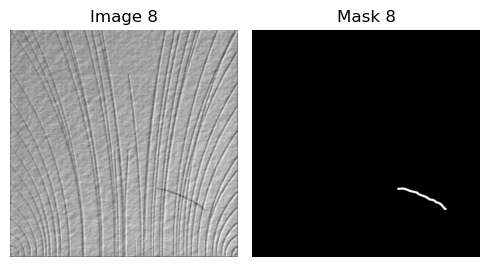

In [466]:
%matplotlib inline
idx = 8
image, image_mask, image_class, image_name = test_dataset[idx]
image_key = dagm_build_key(str(image_class), image_name)
image, image_mask = image.squeeze(), image_mask.squeeze()
titles = [f"Image {idx}", f"Mask {idx}"]
plot_images([image, image_mask], titles, rows=1, cols=2)

Notations:

$$
\begin{align*}
L &:=\text{image size} &=512\\
l &:=\text{patch size} &=128\\
c &:=\text{center size} &=32\\
c' &:=\text{content size} &=24\\
s &:=\text{stride} &=16\\
mp &:=\text{minimum padding} &=52\\
m &:=\text{margin} &=8\\
p &:=\text{total padding} &=60\\
\end{align*}
$$

In order to compute how much padding we need to add to each image, we must take into account several considerations.

In the first place, we want the first patch to have its content region (the center $24\times24$ region) placed on the top-leftmost pixel of the original, unpadded image. Thus, we have a _minimum padding_ ($mp$), which will be the required padding to add for the first patch to be able to reside with their center $24\times24$ regions on the $(0, 0)$ coordinates of the original image:
$$mp = \frac{l - c'}{2}$$

Second, if we slide a $24\times24$ window with stride $16$ over the original image, the last patch might require an additional margin because it won't fit. Let's call this margin $m$:
$$m = (s - ((L - c')\mod s))\mod s$$

Lastly, the total padding required, $p$, will be the sum of the minimum padding and the margin:
$$p=mp+m$$


Minimum required padding: 52
Additional margin: 8
Total padding: 60
Padded image shape: torch.Size([632, 632])
Number of windows: 32


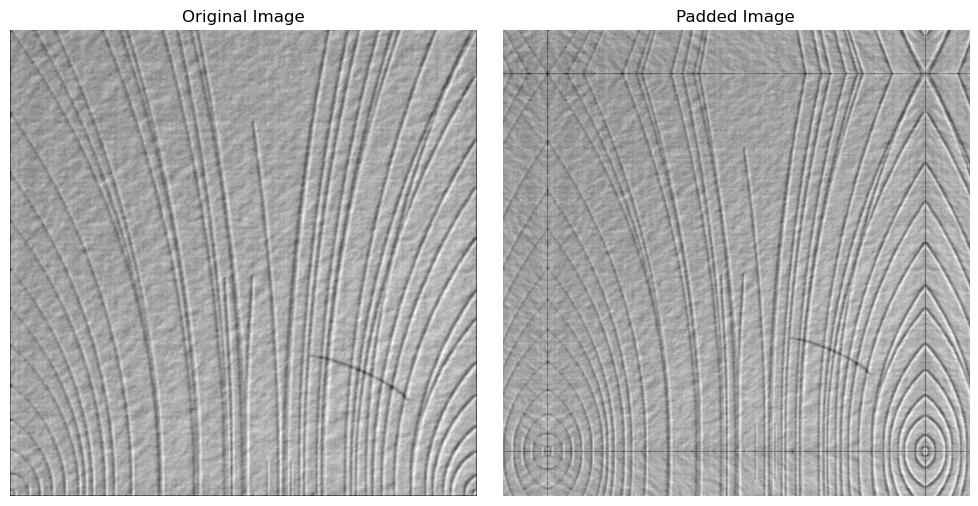

In [467]:
padded_image, min_pad, margin, pad_size = pad_image(config, image.unsqueeze(0))
image_length = image.shape[-1]
num_windows = (image_length + 2 * pad_size - config.patch_size) // config.stride + 1
print(f"Minimum required padding: {min_pad}")
print(f"Additional margin: {margin}")
print(f"Total padding: {pad_size}")
print(f"Padded image shape: {padded_image.shape}")
print(f"Number of windows: {num_windows}")
plot_images([image, padded_image], ["Original Image", "Padded Image"], rows=1, cols=2, figsize=(10, 5))

#### Load inpainted image if possible, otherwise run inference process and save inpainted image

##### Load inpainted image

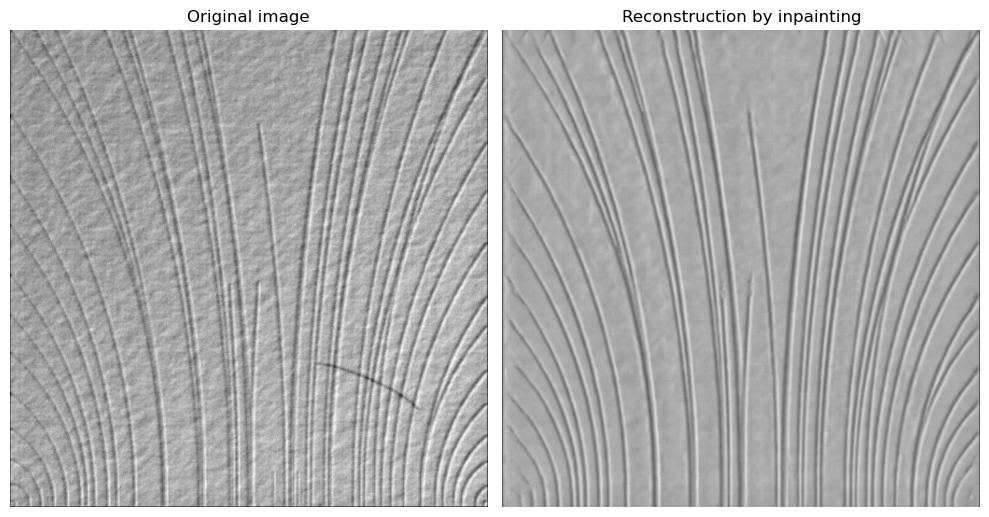

In [468]:
inpainted_image = save_manager.try_load_inpainting(image_key, run_name, checkpoint_name)
if inpainted_image is None:
    print("Inpainted image could not be loaded!")
else:
    plot_images(
        [image, inpainted_image],
        ["Original image", "Reconstruction by inpainting"],
        rows=1,
        cols=2,
        figsize=(10, 10),
    )

##### Compute a new one

Patches processed: 100%|██████████| 1024/1024 [00:08<00:00, 117.03patch/s]


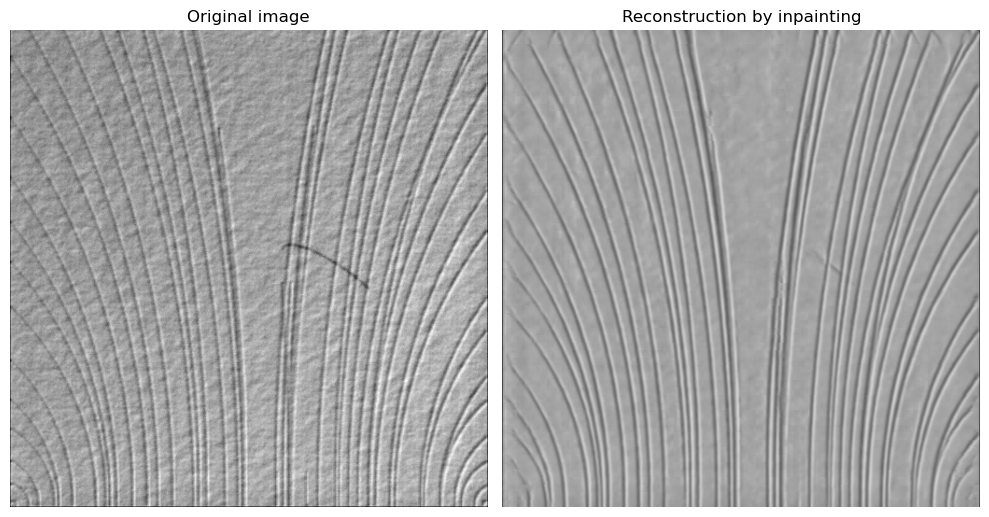

In [384]:
%matplotlib inline
patches = []
inputs = []
outputs = []
titles = []
image_contents = []
inpainted_contents = []
mask = torch.asarray(create_center_mask(image_size=config.patch_size, center_size=config.center_size))
with tqdm(total=num_windows**2, desc="Patches processed", unit="patch") as pbar, torch.no_grad():
    for i in range(num_windows):
        for j in range(num_windows):
            tli, bri = margin + i * config.stride, margin + i * config.stride + config.patch_size  # top-left
            tlj, brj = margin + j * config.stride, margin + j * config.stride + config.patch_size  # bottom-right
            patch = padded_image[tli:bri, tlj:brj]
            # for patch in patches:
            input = normalize_to_mean_std(
                patch.unsqueeze(0).unsqueeze(0), mean=0.5267019737681685, std=0.19957033073362934
            )
            input = input * (1 - mask)
            input = input.to(config.device)
            output = model(input)
            output = normalize_to_mean_std(output, mean=image.mean(), std=image.std())
            tl, br = (config.patch_size - config.content_size) // 2, (config.patch_size + config.content_size) // 2
            image_contents.append(patch[tl:br, tl:br])
            inpainted_contents.append(output.detach().squeeze().cpu().numpy()[tl:br, tl:br])
            outputs.append(output.detach().squeeze().cpu().numpy())
            pbar.update(1)
inpainted_contents = torch.asarray(np.array(inpainted_contents))

diffs = [torch.abs(torch.asarray(input) - torch.asarray(output)) for input, output in zip(inputs, outputs)]
content_mask = create_center_mask(128, 24)
contents = [diff * content_mask for diff in diffs]

image_size = image.shape[-1]
inpainted_image = torch.zeros((image_size + margin, image_size + margin))
weights = torch.zeros((image_size + margin, image_size + margin))
for i in range(num_windows):
    for j in range(num_windows):
        tli, bri = i * config.stride, i * config.stride + config.content_size
        tlj, brj = j * config.stride, j * config.stride + config.content_size
        inpainted_image[tli:bri, tlj:brj] += torch.asarray(inpainted_contents[i * num_windows + j])
        weights[tli:bri, tlj:brj] += 1
inpainted_image /= weights
inpainted_image = inpainted_image[:image_size, :image_size]
plot_images(
    [image, inpainted_image],
    ["Original image", "Reconstruction by inpainting"],
    rows=1,
    cols=2,
    figsize=(10, 10),
)

### Test the recommendation algorithm

Recommended threshold: 0.58
AUPRC: 0.26523542404174805


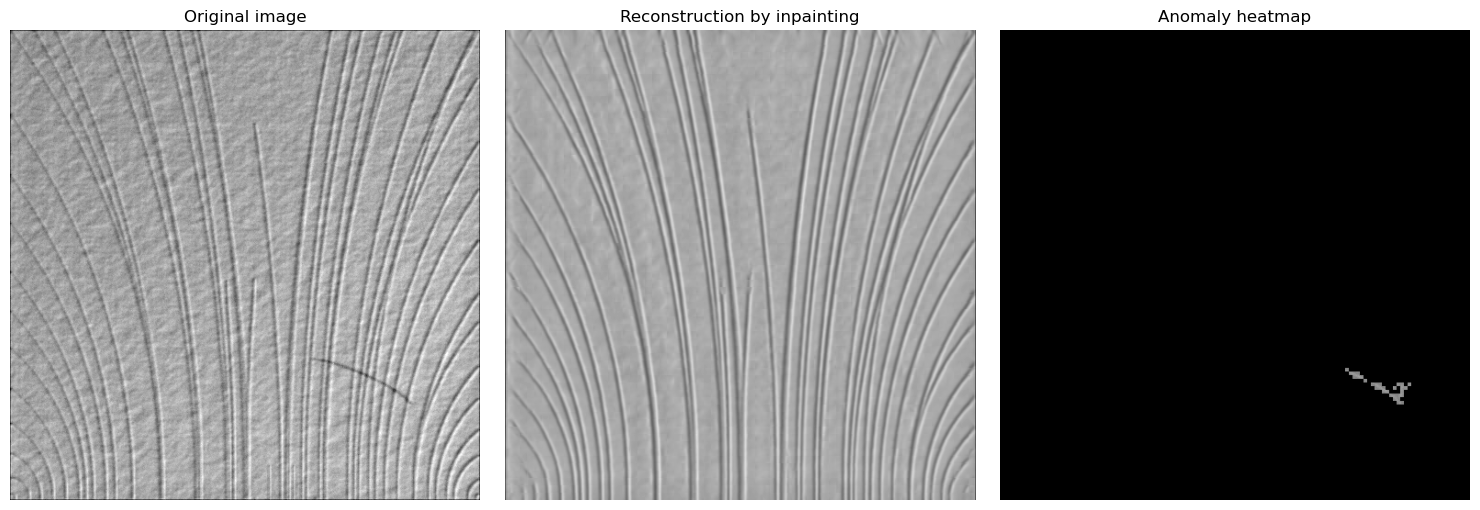

Testing with other recommendations:
Threshold: 0.58, AUPRC: 0.26523542404174805


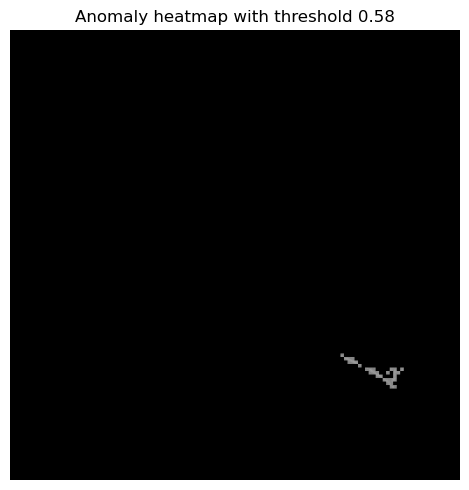

In [469]:
from src.deep_ad.eval import compute_anomaly_heatmap_adaptive, compute_anomaly_heatmap

config.hm_patch_size = 4
anomaly_heatmap, recommended_threshold, recommended_thresholds = compute_anomaly_heatmap_adaptive(config, image, inpainted_image)
auprc = binary_auprc(anomaly_heatmap.reshape(-1), image_mask.reshape(-1))
print(f"Recommended threshold: {recommended_threshold}")
print(f"AUPRC: {auprc}")
plot_images(
    [image, inpainted_image, anomaly_heatmap],
    ["Original image", "Reconstruction by inpainting", "Anomaly heatmap"],
    rows=1,
    cols=3,
    figsize=(15, 5),
)

print(f"Testing with other recommendations:")
heatmaps = []
for other_threshold in recommended_thresholds:
    anomaly_heatmap = compute_anomaly_heatmap(config, image, inpainted_image, threshold=other_threshold)
    heatmaps.append(anomaly_heatmap)
    auprc = binary_auprc(anomaly_heatmap.reshape(-1), image_mask.reshape(-1))
    print(f"Threshold: {other_threshold}, AUPRC: {auprc}")

plot_images(
    heatmaps,
    [f"Anomaly heatmap with threshold {threshold}" for threshold in recommended_thresholds],
    rows=1,
    cols=len(heatmaps),
    figsize=(15, 5),
)

#### Postprocessing

diff_01: mean=0.09063422679901123, min=0.0, max=1.0, std=0.07391005009412766
wdiff: mean=0.45317113399505615, min=0.0, max=5.0, std=0.36955025792121887
postproc: mean=0.6070855259895325, min=0.5, max=0.9933071732521057, std=0.07799819856882095
Min pixel: 0.538753092288971
Second min pixel: 0.5512169003486633
Third min pixel: 0.551620602607727
Max pixel: 0.9459600448608398
Second max pixel: 0.9362532496452332
Third max pixel: 0.9332496523857117
threshold=0.00, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.01, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.02, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.03, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.04, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.05, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.06, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.07, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.08, AUPRC=0.0197, len(sizes)=1, max(sizes)=4.0
threshold=0.09, AUPRC

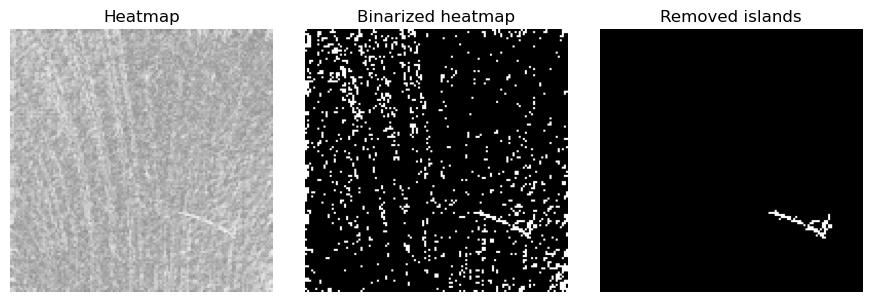

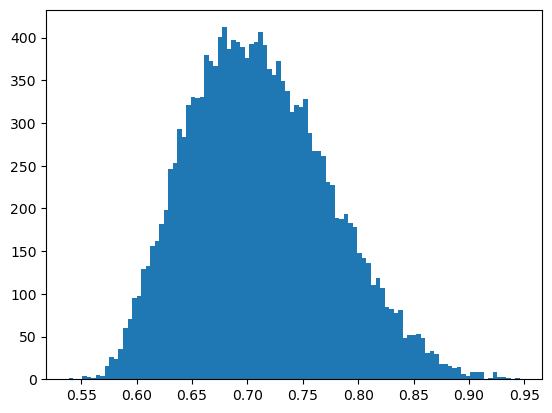

In [476]:
%matplotlib inline
from torch.nn.functional import sigmoid
from src.deep_ad.eval import binarize_heatmap, remove_islands
from scipy.ndimage import label as scipy_label

config.hm_patch_size = 4

image_normed = normalize_to_mean_std(image.unsqueeze(0).unsqueeze(0), mean=0.5267019737681685, std=0.19957033073362934).squeeze()
inpainted_normed = normalize_to_mean_std(inpainted_image.unsqueeze(0).unsqueeze(0), mean=0.5267019737681685, std=0.19957033073362934).squeeze()
diff_image = torch.abs(image_normed - inpainted_normed)
weight = 5
diff_01 = (diff_image - diff_image.min()) / (diff_image.max() - diff_image.min())
# diff_01 = diff_image
# wdiff = weight * (diff_01 - 0.5)
wdiff = weight * diff_01
print(f"diff_01: mean={diff_01.mean()}, min={diff_01.min()}, max={diff_01.max()}, std={diff_01.std()}")
print(f"wdiff: mean={wdiff.mean()}, min={wdiff.min()}, max={wdiff.max()}, std={wdiff.std()}")
postproc = sigmoid(wdiff)
# postproc = wdiff
print(f"postproc: mean={postproc.mean()}, min={postproc.min()}, max={postproc.max()}, std={postproc.std()}")
diff_image = postproc

# HEATMAP
patch_surface = config.hm_patch_size ** 2
hm_num_windows = (diff_image.shape[-1] - config.hm_patch_size) // config.hm_patch_size + 1
# Cut the margins
diff_cut = cut_margins(diff_image.clone(), margin=2)
patch_metric = lambda patch: patch.max()
heatmap = compute_heatmap(diff_cut, config.hm_patch_size, hm_num_windows, patch_metric)

max_pixel = heatmap.max()
second_max_pixel = heatmap[heatmap < max_pixel].max()
third_max_pixel = heatmap[heatmap < second_max_pixel].max()
min_pixel = heatmap.min()
second_min_pixel = heatmap[heatmap > min_pixel].min()
third_min_pixel = heatmap[heatmap > second_min_pixel].min()
print(f"Min pixel: {min_pixel}")
print(f"Second min pixel: {second_min_pixel}")
print(f"Third min pixel: {third_min_pixel}")
print(f"Max pixel: {max_pixel}")
print(f"Second max pixel: {second_max_pixel}")
print(f"Third max pixel: {third_max_pixel}")

# # Remove islands
# structure = torch.ones((3, 3))
# labeled_image, num_features = scipy_label(hmb.cpu().numpy(), structure=structure)
# sizes = np.bincount(labeled_image.flatten())
# # Get the maximum value of each island
# max_values = np.zeros_like(sizes, dtype=np.float32)
# for i in range(1, num_features + 1):
#     max_values[i] = heatmap[labeled_image == i].max()
# min_values = np.zeros_like(sizes, dtype=np.float32)
# for i in range(1, num_features + 1):
#     min_values[i] = heatmap[labeled_image == i].min()
# sizes[0] = 0  # Discard background denoted by 0
# sorted_islands = np.argsort(sizes)
# # biggest_island = sizes[sorted_islands[-1]]
# # keep_labels = sorted_islands[sizes[sorted_islands] >= int(biggest_island * 0.8)]
# # Keep labels that have max_values[label] == max_pixel
# keep_labels = sorted_islands[max_values[sorted_islands] > third_max_pixel.item()]
# print(f"Sizes of kept labels: {sizes[keep_labels]}")
# print(f"Max values of kept labels: {max_values[keep_labels]}")
# print(f"Min values of kept labels: {min_values[keep_labels]}")
# mask = torch.zeros_like(image)
# for label in keep_labels:
#     mask = torch.logical_or(mask, torch.asarray(labeled_image == label))
# hmr = hmb * mask

auprcs = []
thresholds = []
sizes_mat = []
max_values_mat = []
min_values_mat = []
mean_values_mat = []
for threshold in np.arange(0.0, 1.0, 0.01):
    hmb = binarize_heatmap(heatmap, threshold=threshold)
    hmr, sizes, max_values, min_values, mean_values = remove_islands(heatmap_bin=hmb, heatmap=heatmap)
    sizes_mat.append(np.array(sizes))
    max_values_mat.append(np.array(max_values))
    min_values_mat.append(np.array(min_values))
    mean_values_mat.append(np.array(mean_values))
    auprc = binary_auprc((diff_image * hmr).reshape(-1), image_mask.reshape(-1)).item()
    auprcs.append(auprc)
    thresholds.append(threshold)
    print(f"threshold={threshold:.2f}, AUPRC={auprc:.4f}, len(sizes)={len(sizes)}, max(sizes)={max(sizes) // patch_surface / 4096}")

best_threshold = thresholds[np.argmax(auprcs)]
hmb = binarize_heatmap(heatmap, threshold=best_threshold)
hmr, _, _, _, _ = remove_islands(heatmap_bin=hmb, heatmap=heatmap)

print(f"Best threshold: {best_threshold}, Best AUPRC: {np.max(auprcs)}")
plot_images([heatmap, hmb, hmr], ["Heatmap", "Binarized heatmap", "Removed islands"], rows=1, cols=3, figsize=(9, 3))
plt.show()
plt.hist(torch.unique(heatmap), bins=100)
plt.show()

In [475]:
max_values = np.array([max(values) for values in max_values_mat])
min_values = np.array([min(values) for values in min_values_mat])
mean_values = np.array([np.mean(sizes * mean_values) for sizes, mean_values in zip(sizes_mat, mean_values_mat)])

# Threshold recommendation
max_sizes = np.array([max(sizes) for sizes in sizes_mat])
max_sizes_diff = -np.diff(max_sizes)
diff_over_max = max_sizes_diff / max_sizes[:-1]
for t, au, d, ms, dms in zip(thresholds[:-1], auprcs, max_sizes_diff, max_sizes[:-1], diff_over_max):
    print(f"threshold={t:.2f}, auprc={au:.3f} max_size_diff={d / patch_surface}, max_size={ms / patch_surface}, diff/max_size={dms:.3f}")
thresholds = np.array(thresholds)
auprcs = np.array(auprcs)

# Remove threholds that have max island greater than 50% of the image
keep_thresholds = max_sizes / patch_surface / 4096 < 0.5
# Remove thresholds that don't have islands
keep_thresholds = np.logical_and(keep_thresholds, max_sizes > 0)
# Find the first threshold that has a diff/max_size ratio greater than 0.5. This could be where the background starts to be removed. 
# keep_thresholds[:-1] = np.logical_and(keep_thresholds[:-1], diff_over_max < 0.4)
# Now, recommend the first threshold
recommended_threshold = thresholds[keep_thresholds][0]
recommended_size = max_sizes[keep_thresholds][0]
# But, keep all the thresholds which have the max size at least half of the size corresponding to the recommended threshold
keep_thresholds = np.logical_and(keep_thresholds, max_sizes >= recommended_size / 2)

# TODO Maybe look for thresholds with size close to the recommended threshold, because they might be good options as well, and then choose one at random

print(f"Keeping the following thresholds:")
for threshold, auprc, max_s, max_s_d, max_v, min_v, mean_v in zip(
    thresholds[keep_thresholds],
    auprcs[keep_thresholds],
    max_sizes[keep_thresholds],
    diff_over_max[keep_thresholds[:-1]],
    max_values[keep_thresholds],
    min_values[keep_thresholds],
    mean_values[keep_thresholds],
):
    print(
        f"threshold={threshold:.2f}, AUPRC={auprc:.4f}, max(sizes)={max_s / patch_surface}, max(sizes)/diff={max_s_d}, max(max_values)={max_v:.3f}, min(min_values)={min_v:.3f}, mean(mean_values)={mean_v:.3f}"
    )

print(f"Recommended threshold: {recommended_threshold}, corresponding AUPRC: {auprcs[keep_thresholds][0]:.4f}")

threshold=0.00, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.01, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.02, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.03, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.04, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.05, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.06, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.07, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.08, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.09, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.10, auprc=0.020 max_size_diff=0.0, max_size=16384.0, diff/max_size=0.000
threshold=0.11, auprc=0.020 max_size_diff=0.0, max_size=16384.0, 

C:\Users\popas\AppData\Local\Temp\ipykernel_21556\244015487.py:8: RuntimeWarning: invalid value encountered in divide
  diff_over_max = max_sizes_diff / max_sizes[:-1]


diff_01: mean=0.10042190551757812, min=0.0, max=1.0, std=0.0811210349202156
wdiff: mean=-1.497890591621399, min=-2.0, max=3.0, std=0.40560516715049744
postproc: mean=0.1897512525320053, min=0.11920291930437088, max=0.9525741338729858, std=0.07098003476858139


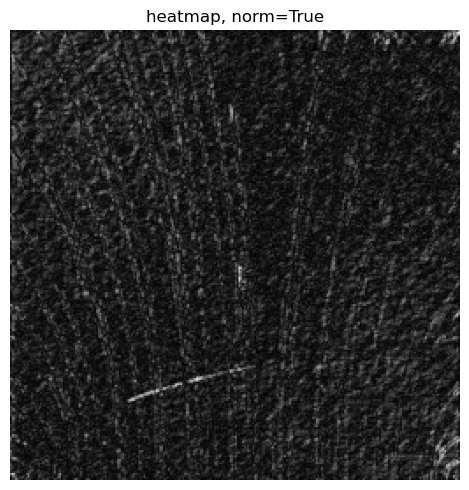

In [430]:
%matplotlib inline

diff_image = compute_diff(image, inpainted_image, norm=True)
config.hm_patch_size = 2
hm_num_windows = (diff_image.shape[-1] - config.hm_patch_size) // config.hm_patch_size + 1
# Cut the margins
diff_cut = cut_margins(diff_image.clone(), margin=1)
patch_metric = lambda patch: patch.max()
heatmap = compute_heatmap(diff_cut, config.hm_patch_size, hm_num_windows, patch_metric)

plot_images([heatmap], ["heatmap, norm=True"], range="01", cmap='gray', rows=1, cols=1)

In [131]:
%matplotlib inline
diff_fl = diff_image.flatten()
max_threshold = torch.mean(torch.sort(diff_fl)[0][-int(len(diff_fl) * 0.01):])
thresholds = np.arange(max(0, max_threshold - 0.5), max_threshold, 0.001)
auprcs = []
all_island_sizes = []
for threshold in tqdm(thresholds):
    hmc = heatmap.clone()
    hmc[hmc < threshold] = 0
    hmc[hmc >= threshold] = 1
    hmc, island_sizes = remove_islands(hmc)
    all_island_sizes.append(island_sizes)
    auprcs.append(binary_auprc((diff_image * hmc).reshape(-1), image_mask.reshape(-1)).item())

100%|██████████| 500/500 [00:05<00:00, 95.75it/s] 


AUPRC>=0.3: 0.533-0.840
AUPRC>=0.35: 0.533-0.825
AUPRC>=0.4: 0.533-0.786
AUPRC>=0.45: 0.533-0.783
AUPRC>=0.5: 0.533-0.643
AUPRC>=0.55: 0.533-0.643
AUPRC>=0.6: 0.584-0.643
AUPRC>=0.65: 0.584-0.643
AUPRC>=0.7: 0.584-0.643
AUPRC>=0.75: 0.584-0.643
AUPRC>=0.8: 0.584-0.643
AUPRC>=0.8184166550636292: 0.584-0.586


Text(0, 0.5, 'AUPRC')

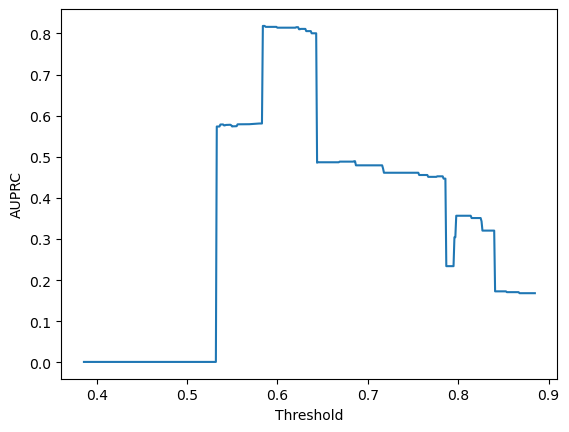

In [134]:
%matplotlib inline
auprcs = np.array(auprcs)
for auprc_threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, max(auprcs)]:
    auprc_thresholds = thresholds[auprcs >= auprc_threshold]
    if len(auprc_thresholds) == 0:
        auprc_thresholds = [float("nan")]
    print(f"AUPRC>={auprc_threshold}: {auprc_thresholds[0]:.3f}-{auprc_thresholds[-1]:.3f}")
plt.plot(thresholds, auprcs)
plt.xlabel("Threshold")
plt.ylabel("AUPRC")

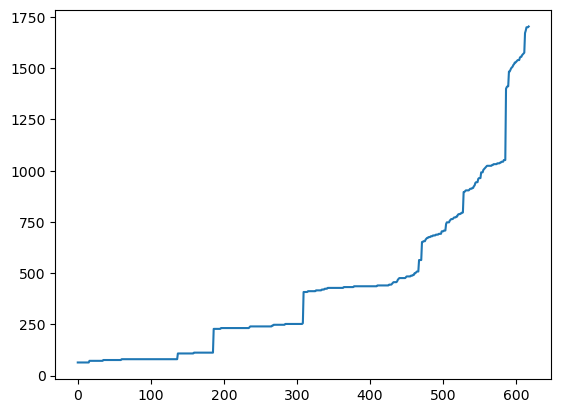

median_size: 408
lower: 285.59999999999997, upper: 530.4
Island lengths in [lower, upper]: 158/618
Number of thresholds with islands in [lower, upper]: 111/500
Good thresholds lie in range [0.533-0.643]
Good thresholds 2 lie in range [0.584-0.643]
best_threshold: 0.6133863627910614
corresponding AUPRC: 0.04829522222280502


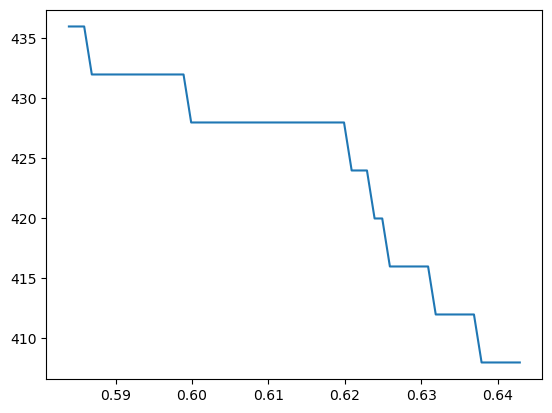

In [181]:
%matplotlib inline
def flatten(xs):
    return [x for ys in xs for x in ys]
all_fl = np.sort(np.array(flatten(all_island_sizes)))
plt.plot(all_fl)
plt.show()
err = 30 / 100
median_size = all_fl[len(all_fl) // 2]
print(f"median_size: {median_size}")
lower = median_size * (1 - err)
upper = median_size * (1 + err)
print(f"lower: {lower}, upper: {upper}")
print(f"Island lengths in [lower, upper]: {np.sum(np.logical_and(all_fl >= lower, all_fl <= upper))}/{len(all_fl)}")
good_thresholds_mask = [any(lower <= size <= upper for size in sublist) for sublist in all_island_sizes]
print(f"Number of thresholds with islands in [lower, upper]: {sum(good_thresholds_mask)}/{len(all_island_sizes)}")
good_thresholds = thresholds[good_thresholds_mask]
print(f"Good thresholds lie in range [{good_thresholds[0]:.3f}-{good_thresholds[-1]:.3f}]")
good_thresholds_mask2 = [good and len(sublist) == 1 for good, sublist in zip(good_thresholds_mask, all_island_sizes)]
good_thresholds2 = thresholds[good_thresholds_mask2]
good_island_sizes2 = np.array([sublist for good, sublist in zip(good_thresholds_mask2, all_island_sizes) if good]).flatten()
print(f"Good thresholds 2 lie in range [{good_thresholds2[0]:.3f}-{good_thresholds2[-1]:.3f}]")
best_threshold = np.median(good_thresholds2)

hmc = heatmap.clone()
hmc[hmc < best_threshold] = 0
hmc[hmc >= best_threshold] = 1
hmc, _ = remove_islands(hmc)
best_auprc = binary_auprc((diff_image * hmc).reshape(-1), image_mask.reshape(-1)).item()
print(f"best_threshold: {best_threshold}")
print(f"corresponding AUPRC: {best_auprc}")
plt.plot(good_thresholds2, good_island_sizes2)

In [437]:
%matplotlib tk
from matplotlib.widgets import Slider


def apply_transforms(image: torch.Tensor, threshold: float, width: int) -> torch.Tensor:
    hmc = heatmap.clone()
    hmc[hmc < threshold] = 0
    hmc[hmc >= threshold] = 1
    hmc, _, _, _, _ = remove_islands(heatmap, hmc)
    if width > 0:
        image[:width, :] = 0
        image[-width:, :] = 0
        image[:, :width] = 0
        image[:, -width:] = 0
    image = image * hmc
    return image

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(bottom=0.25)

threshold = 0.625
slider_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])
slider_threshold = Slider(slider_ax, "Threshold", 0, 1, valinit=threshold, valstep=0.001)

width = 0
slider_width = Slider(fig.add_axes([0.2, 0.15, 0.6, 0.03]), "Width", 0, 100, valinit=width, valstep=1)

initial_image = apply_transforms(diff_image.clone(), threshold, width)
im = axs.imshow(initial_image, vmin=0, vmax=1, cmap='gray')
im_title = fig.suptitle(f"AUPRC: {binary_auprc(initial_image.reshape(-1), image_mask.reshape(-1))}")

def update_plot(new_image: torch.Tensor) -> None:
    global im, im_title, fig
    im.set_data(new_image)
    im_title.set_text(f"AUPRC: {binary_auprc(new_image.reshape(-1), image_mask.reshape(-1))}")
    fig.canvas.draw_idle()

def update_threshold(val: float) -> None:
    global threshold, width
    threshold = val
    diff_thresholded = apply_transforms(diff_image.clone(), threshold, width)
    update_plot(diff_thresholded)

def update_width(val: float) -> None:
    global width
    width = int(val)
    diff_thresholded = apply_transforms(diff_image.clone(), threshold, width)
    update_plot(diff_thresholded)

slider_threshold.on_changed(update_threshold)
slider_width.on_changed(update_width)
plt.show()

NameError: name 'diff_patches' is not defined

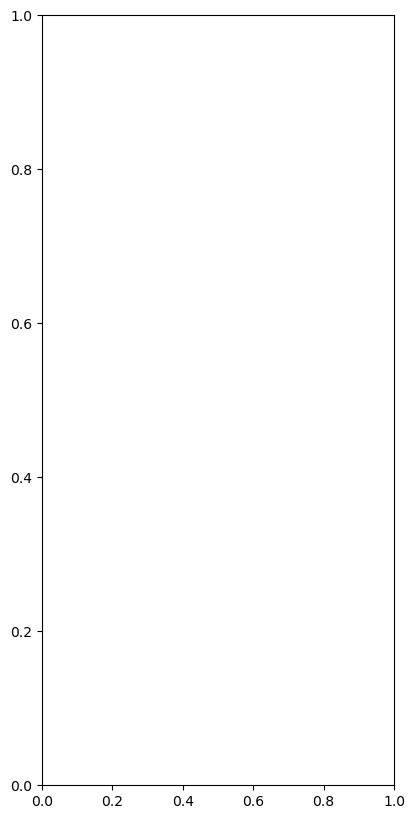

In [13]:
%matplotlib inline
import matplotlib.patches as mpl_patches

sw_stride = 8
sw_size = 8
sw_num_windows = (diff_image.shape[-1] - sw_size) // sw_stride + 1

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
row, col = 19, 50
plt.imshow(diff_patches[row * sw_num_windows + col], vmin=0, vmax=1, cmap="plasma")

ax = plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(diff_image.numpy(), cv.COLOR_GRAY2RGB))
rect = mpl_patches.Rectangle((col * sw_stride, row * sw_stride), sw_size, sw_size, facecolor='red', edgecolor='red', alpha=1)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [20]:
mse_metric = define_mse_metric()
mse = mse_metric(image, inpainted_image)
print(f"MSE: {mse}")
my_mse = torch.sum((image - inpainted_image) ** 2) / (image.shape[-1] * image.shape[-2])
print(f"My MSE: {my_mse}")
print(f"MSE == My MSE?: {mse == my_mse}")

rmse_metric = define_rmse_metric()
rmse = rmse_metric(image, inpainted_image)
print(f"RMSE: {rmse}")
my_rmse = torch.sqrt(my_mse)
print(f"My RMSE: {my_rmse}")
print(f"RMSE == My RMSE?: {rmse == my_rmse}")

psnr_metric = define_psnr_metric()
psnr = psnr_metric(inpainted_image, image)
print(f"PSNR: {psnr}")
my_psnr = 20 * torch.log10(torch.max(image)) - 10 * torch.log10(my_mse)
print(f"My PSNR: {my_psnr}")
print(f"PSNR ==(close) My PSNR?: {torch.allclose(psnr, my_psnr)}")

MSE: 0.005090771708637476
My MSE: 0.005090771708637476
MSE == My MSE?: True
RMSE: 0.07134964317083359
My RMSE: 0.07134964317083359
RMSE == My RMSE?: True
PSNR: 22.898035049438477
My PSNR: 22.89803695678711
PSNR ==(close) My PSNR?: True
